In [1]:
import torch
import torchvision
from torchvision.models import VGG11_Weights
import torchvision.transforms as transforms
from torch.utils.data import DataLoader as tf_dataloader
from torch.utils.data import Subset
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import torch.optim as optim

In [2]:
transform = transforms.Compose([
    #transforms.Resize(256),
    #transforms.CenterCrop(224),
    transforms.ToTensor(), 
    transforms.Normalize((0.5,), (0.5,))
])

batch_size = 1

# Train data
trainset = torchvision.datasets.CIFAR10(
    root="./data", train=True, download=True, transform=transform
)
trainloader = tf_dataloader(
    trainset, batch_size=batch_size, shuffle=True, num_workers=2
)


# Test data
testset = torchvision.datasets.CIFAR10(
    root="./data", train=False, download=True, transform=transform
)
testloader = tf_dataloader(
    testset, batch_size=batch_size, shuffle=False, num_workers=2
)


Files already downloaded and verified
Files already downloaded and verified


In [3]:
# functions to show an image
def imshow(img):
    plt.figure(figsize=(2, 2))
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis("off")
    plt.show()

tensor([1])


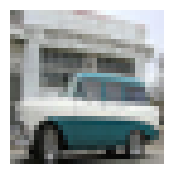

In [4]:
# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)
print(labels)
imshow(torchvision.utils.make_grid(images))

tensor([3])


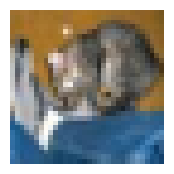

In [5]:
# get some random training images
dataiter = iter(testloader)
images, labels = next(dataiter)
print(labels)
imshow(torchvision.utils.make_grid(images))

In [6]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.layer2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.layer3 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.layer4 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.layer5 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.layer6 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.layer7 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.layer8 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.layer9 = nn.Flatten()
        self.drop1 = nn.Dropout(p=0.2)
        
        self.fc1 = nn.Linear(in_features=512, out_features=128)  # Cambiado de 256 a 1024
        self.drop2 = nn.Dropout(p=0.2)
        self.fc2 = nn.Linear(in_features=128, out_features=256)
        self.drop3 = nn.Dropout(p=0.2)
        self.fc3 = nn.Linear(in_features=256, out_features=10)

    def forward(self, x):
        self.x1 = self.layer1(x)
        self.x2 = F.elu(self.layer2(self.x1))
        self.x3 = self.layer3(self.x2)
        self.x4 = F.elu(self.layer4(self.x3))
        self.x5 = self.layer5(self.x4)
        self.x6 = F.elu(self.layer6(self.x5))
        self.x7 = self.layer7(self.x6)
        self.x8 = F.elu(self.layer8(self.x7))
        self.x9 = self.layer9(self.x8)
        self.x10 = self.drop1(self.x9)
        
        self.x11 = F.relu(self.fc1(self.x10))
        self.x12 = self.drop2(self.x11)
        self.x13 = F.relu(self.fc2(self.x12))
        self.x14 = self.drop3(self.x13)
        self.x15 = self.fc3(self.x14)
            
        return self.x9, F.log_softmax(self.x15, dim=1)

net = Net()
#net.to(mps_device)

In [7]:
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [8]:
epochs = 50
patience = 10  # Define the number of epochs to tolerate before early stopping
best_loss = float('inf')
counter = 0

y = []
images = []
tensors = []

for epoch in range(epochs):
    
    train_loss = 0.0
    test_loss = 0.0
    train_correct = 0
    test_correct = 0
    
    # Train 
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        tensor, outputs = net(inputs)
        _, predicted = torch.max(outputs.data, 1)
        train_correct += (predicted == labels).sum().item()
        
        loss = F.nll_loss(outputs, labels)
        loss.backward()
        optimizer.step()
        
        # print statistics
        train_loss += loss.item()
        
        # print train_loss each time i is multiple of 1000
        if i % 10000 == 0:
            print(f'Train loss at step {i}: {train_loss/(i+1):.3f}')
        
        # If we are in the last epoch or the patience has been reached, save all batches of images and labels
        if epoch == epochs - 1 or counter == patience - 1:
            images.append(inputs)
            y.append(labels)
            tensors.append(tensor)
    
    
    net.eval()  # Set the model to evaluation mode
    with torch.no_grad():
        for inputs, labels in testloader:
            _, outputs = net(inputs)
            _, predicted = torch.max(outputs.data, 1)
            test_correct += (predicted == labels).sum().item()
            loss = F.nll_loss(outputs, labels)
            test_loss += loss.item()
    
    # Print test loss for the epoch
    print("-----------------------------------")
    print(f"Epoch {epoch + 1}")
    print(f"Train Loss: {train_loss / len(trainloader):.3f}")
    print(f"Test Loss: {test_loss / len(testloader):.3f}")
    print(f'Train Accuracy: {100 * train_correct / len(trainloader):.3f}%')
    print(f'Test Accuracy: {100 * test_correct / len(testloader):.3f}%')
    print("-----------------------------------")
    

    # Check for early stopping
    if test_loss < best_loss:
        best_loss = test_loss
        counter = 0
        # Save the best model
        torch.save(net.state_dict(), 'best_model_CIFAR_NEW.pth')
    else:
        counter += 1
        if counter >= patience:
            print(f"Early stopping at epoch {epoch + 1}")
            break
    
    # If we are not in the last epoch and the patience has not been reached, empty the lists
    if epoch != epochs - 1 and counter != patience - 1:
        images = []
        y = []
        tensors = []
    
print("Finished Training")

Train loss at step 0: 2.327
Train loss at step 10000: 2.006
Train loss at step 20000: 1.834
Train loss at step 30000: 1.735
Train loss at step 40000: 1.674
-----------------------------------
Epoch 1
Train Loss: 1.638
Test Loss: 1.456
Train Accuracy: 39.904%
Test Accuracy: 48.620%
-----------------------------------
Train loss at step 0: 0.042
Train loss at step 10000: 1.281
Train loss at step 20000: 1.280
Train loss at step 30000: 1.282
Train loss at step 40000: 1.284
-----------------------------------
Epoch 2
Train Loss: 1.293
Test Loss: 1.367
Train Accuracy: 55.890%
Test Accuracy: 55.750%
-----------------------------------
Train loss at step 0: 1.921
Train loss at step 10000: 1.329
Train loss at step 20000: 1.347
Train loss at step 30000: 1.360
Train loss at step 40000: 1.377
-----------------------------------
Epoch 3
Train Loss: 1.392
Test Loss: 1.435
Train Accuracy: 54.026%
Test Accuracy: 53.410%
-----------------------------------
Train loss at step 0: 0.002
Train loss at step

In [15]:
# Evaluating the trained model on test data
net.load_state_dict(torch.load('best_model_CIFAR_NEW.pth'))
net.eval()  # Set model to evaluation mode
correct = 0
total = 0

with torch.no_grad():
    for i, data in enumerate(testloader, 0):
        images, labels = data
        _, outputs = net(images)
        predicted = torch.argmax(outputs, dim=1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f'Test Accuracy: {accuracy:.3f} %')

Test Accuracy: 55.750 %


In [10]:
#torch.save(net.state_dict(), f"cnn_trained_{epochs}_epch.pth")
torch.save(images, "train_images_CIFAR_NEW.pth")
torch.save(tensors, "train_tensors_CIFAR_NEW.pth")
torch.save(y, "train_labels_CIFAR_NEW.pth")

tensor([3])


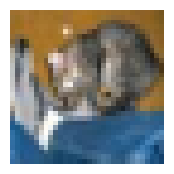

In [11]:
# get some random training images
dataiter = iter(testloader)
images, labels = next(dataiter)
print(labels)
imshow(torchvision.utils.make_grid(images))

In [12]:
_, pred = net(images)
torch.argmax(pred, dim=1)

tensor([3])

In [13]:
net(images)

(tensor([[-0.9930, -0.9878, -0.9963, -0.8219, -0.2888, -0.8694,  0.6914,  1.9509,
          -0.9944, -0.9862, -0.4830,  3.4323,  1.5340,  0.6111, -0.8613, -0.2141,
           3.6032, -0.9924, -0.9237,  3.4550, -0.9999, -0.9985, -0.9723, -0.6630,
           4.7938,  1.5803,  2.0416,  2.2208, -0.9129, -0.6031, -0.7946, -0.7020,
          -0.8485,  1.2802,  1.2127, -0.7024, -0.7740, -0.9272, -0.7948, -0.8730,
          -0.5683, -0.8684, -0.3181,  1.1074, -0.9222, -0.8626, -0.4943, -0.8888,
          -0.9245, -0.9396, -0.5823,  2.4039, -0.9902, -0.9958,  2.5993, -0.8424,
          -0.9955, -0.9966, -0.9910, -0.3339, -0.8818, -0.5255, -0.9977,  1.6696,
          -0.6916,  0.2748,  5.5983,  0.8725, -0.5643, -0.8483, -0.7209,  3.8197,
           1.1725, -0.9275, -0.6779,  0.2903, -0.9718, -0.5031, -0.9859, -0.9219,
           0.2820,  1.4834, -0.7484,  2.6638,  2.6915, -0.2255,  0.2951,  1.9691,
           7.1481, -0.1200, -0.9523, -0.9477,  0.2148, -0.4812,  3.2049, -0.8051,
           1.152